# Finding DNA transcription factor binding motifs using CNN

=> detect specific TF binding site in sequences

=> understand if using CNN able to find a motif


## Exercise description

In this exercise we will learn how CNN can be used to detect a known motif in DNA sequences.
We will focus on FOXO1 transcription factor binding motif from [HOCOMOCO v11](http://hocomoco11.autosome.ru/) [1].
More specifically we will learn how to build CNN model that exploits 1D convolutions in order to detect is a specific window over the genome contains the FOX01 motif aformentioned.

## Data description

The FOXO1 motif considered is 12 bps long. We used probabilties of finding a specific basis in a position of the sequence form HOCOMOCO, to generate our dataset.
The generated dataset is composed by 20000 sequences of length 100 divided in two classes:
1. 10000 sequences sampled using a multinomial distirbution assuming an uniform distribution of bases.
2. 10000 sequences sampled using a multinomial distirbution assuming a distribution given by FOXO1 motif centered in the sequence and padded with uniform distribution of bases.

The sequences are then splitted randomly in two sets with balanced examples from the two classes and saved in the files `FOXO1_train.csv` and `FOXO1_test.csv` in `/sib_autumn_school/jupyter_root/data/motifs`


[1]: "HOCOMOCO: towards a complete collection of transcription factor binding models
for human and mouse via large-scale ChIP-Seq analysis"
Ivan V. Kulakovskiy et al., *Nucl. Acids Res.*, 11 November 2017

In [1]:
# importing needed modules
from __future__ import print_function
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
# fixing seed to ensure reproducibility of the results
np.random.seed(0)

In [3]:
# configuring plotting
%matplotlib inline
sns.set(
    context='notebook',
    style='white',
    palette='colorblind',
    font_scale=2,
    rc = {
        'figure.figsize': (20.0, 10.0)
    }
)

In [4]:
# utilities

# sequences saved on disk
# for each point of the sequence => expand to give nt

def load_data():
    """
    Function to load the data for the exercise.
    
    It returns a tuple of tuples containg:
    ( (x_train, y_train), (x_test, y_test) )
    where:
    - x_* are numpy arrays with shape (number of sequences, sequence length, number of nucleotide bases).
      In a given data point and sequence position a one hot code vector is used to represent the basis:
      - [1, 0, 0, 0] -> A
      - [0, 1, 0, 0] -> C
      - [1, 0, 1, 0] -> G
      - [1, 0, 0, 1] -> T
    - y_* are numpy arrays with shape (number of sequences,).
      For every sequence a binary label is assigned: 1 (it contains the FOXO1 motif), 0 (uniform bases). 
    """
    # file coordinates
    data_path = '/sib_autumn_school/jupyter_root/data'
    train_filepath = '{}/FOXO1_train.csv'.format(data_path)
    test_filepath = '{}/FOXO1_test.csv'.format(data_path)
    print('loading data')
    train = pd.read_csv(train_filepath, index_col=0)
    test = pd.read_csv(test_filepath, index_col=0)
    print('number of train sequences: {}'.format(train.shape[0]))
    print('number of test sequences: {}'.format(test.shape[0]))
    number_of_bases = max(train.values.max(), test.values.max()) + 1
    print('number of bases: {}'.format(number_of_bases))
    # helper for data preparation
    mapping_bases = np.eye(number_of_bases)

    return (
        (
            np.array([
                mapping_bases[sequence]
                for sequence in train.loc[:, train.columns != 'label'].values
            ]),
            train['label']
        ),
        (
            np.array([
                mapping_bases[sequence]
                for sequence in test.loc[:, test.columns != 'label'].values
            ]),
            test['label']
        )
    )


def get_learning_report(history_callback):
    """
    Generate a learning report pandas DataFrame from a keras history callback.
    """
    learning_report = pd.DataFrame(history.history)
    learning_report.index += 1
    learning_report.index.name = 'Epochs'
    learning_report.columns = pd.MultiIndex.from_tuples(
        [
            ('Accuracy', 'Train'), ('Loss', 'Train'),
            ('Accuracy', 'Validation'), ('Loss', 'Validation'),            
        ], names=['Metric','Set']
    )
    return learning_report


def plot_model(model, summary=True):
    """Plot a keras model and conditionally print its summary."""
    if summary:
        print(model.summary())
    return SVG(model_to_dot(model).create(prog='dot', format='svg'))


def plot_learning_report(learning_report):
    """Plot learning report."""
    learning_report['Loss'].plot(title='Loss')
    learning_report['Accuracy'].plot(title='Accuracy')

In [8]:
# loading the data
(x_train, y_train), (x_test, y_test) = load_data()
x_train.shape
# all sequences 100 length with 4 dim vector representing nucleotides

loading data
number of train sequences: 10000
number of test sequences: 10000
number of bases: 4


(10000, 100, 4)

In [6]:
# store some useful variables
# dropout: to avoid overfit
batch_size = 256
epochs = 10
dropout_rate = 0.2
length, number_of_bases = x_train.shape[1:]
learning_reports = {}

## Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 95, 64)            1600      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
None


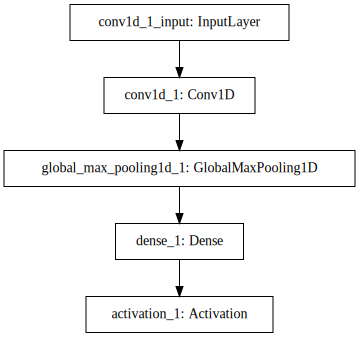

In [7]:
#fix a window to look at 6 nt bases at each time and use 64 different filters

# 6 x 64 x output shape

# how many sliding windows you passed on the sequence

# 1st convolution -> obtained something size 64, then take max (max pooling)

# simple model
filters = 64
kernel_size = 6

model = Sequential()

# apply a first convolutional layer
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(length, number_of_bases)
))


# global max pooling:
model.add(GlobalMaxPooling1D())

# output layer with class prediction
model.add(Dense(1))
model.add(Activation('sigmoid'))


# compilation
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

plot_model(model)

In [9]:
# fitting
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

learning_reports['v1'] = get_learning_report(history)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 5s 462us/step - loss: 0.6906 - acc: 0.5426 - val_loss: 0.6828 - val_acc: 0.6092
Epoch 2/10
10000/10000 [==============================] - 5s 480us/step - loss: 0.6727 - acc: 0.6648 - val_loss: 0.6629 - val_acc: 0.7013
Epoch 3/10
10000/10000 [==============================] - 5s 491us/step - loss: 0.6447 - acc: 0.7167 - val_loss: 0.6320 - val_acc: 0.7494
Epoch 4/10
10000/10000 [==============================] - 5s 494us/step - loss: 0.6097 - acc: 0.7661 - val_loss: 0.5986 - val_acc: 0.7480
Epoch 5/10
10000/10000 [==============================] - 5s 490us/step - loss: 0.5741 - acc: 0.7784 - val_loss: 0.5662 - val_acc: 0.7654
Epoch 6/10
10000/10000 [==============================] - 5s 478us/step - loss: 0.5408 - acc: 0.7896 - val_loss: 0.5384 - val_acc: 0.7719
Epoch 7/10
10000/10000 [==============================] - 5s 484us/step - loss: 0.5115 - acc: 0.7933 - val_loss: 0.5137 - 

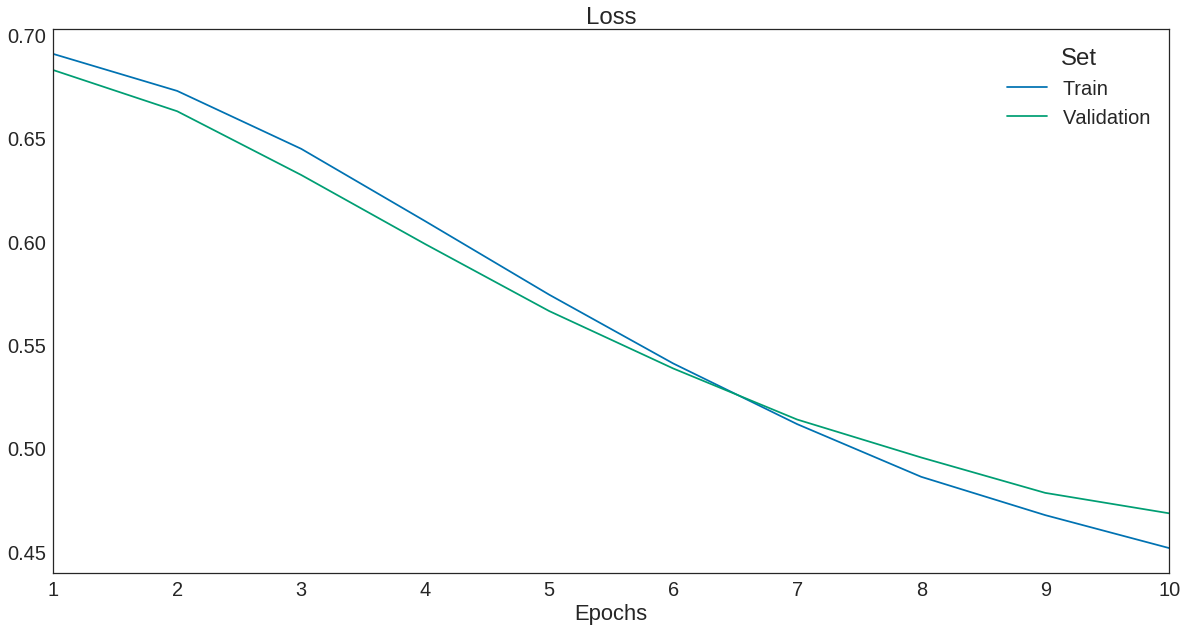

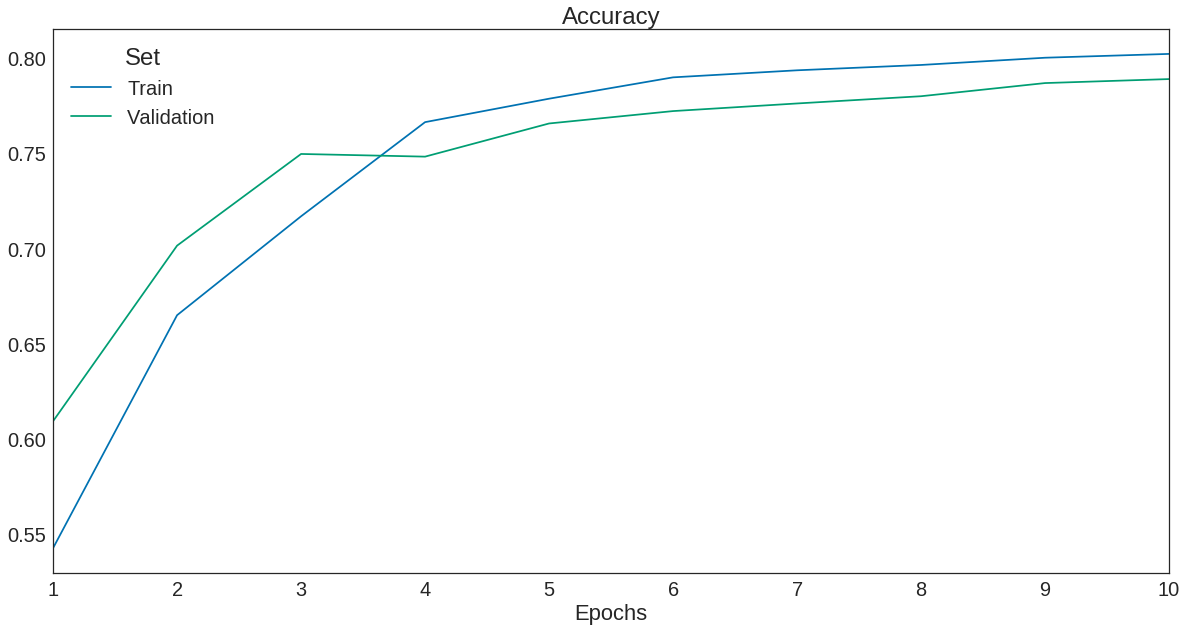

In [10]:
# will need more epoch to converge
# in term of accuracy, already plateauing, already a good classification score

plot_learning_report(learning_reports['v1'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 89, 64)            3136      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________
None


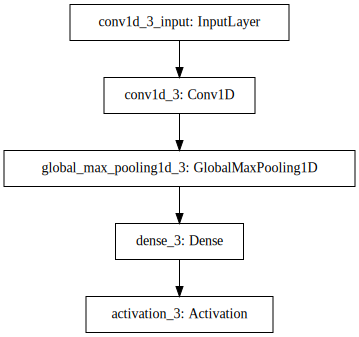

In [12]:
# => try to change the dimension of the window
# same architecture, but increase window size
# double size of the window = double number of weights

# simple model with kernel_size equal motif size
filters = 64
kernel_size = 12

model = Sequential()

# apply a first convolutional layer
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(length, number_of_bases)
))


# global max pooling:
model.add(GlobalMaxPooling1D())

# output layer with class prediction
model.add(Dense(1))
model.add(Activation('sigmoid'))


# compilation
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

plot_model(model)

In [13]:
# fitting
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

learning_reports['v2'] = get_learning_report(history)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 5s 471us/step - loss: 0.6780 - acc: 0.5886 - val_loss: 0.6536 - val_acc: 0.7054
Epoch 2/10
10000/10000 [==============================] - 5s 468us/step - loss: 0.6194 - acc: 0.7561 - val_loss: 0.5813 - val_acc: 0.7890
Epoch 3/10
10000/10000 [==============================] - 4s 445us/step - loss: 0.5320 - acc: 0.8156 - val_loss: 0.4945 - val_acc: 0.8147
Epoch 4/10
10000/10000 [==============================] - 4s 445us/step - loss: 0.4526 - acc: 0.8312 - val_loss: 0.4350 - val_acc: 0.8232
Epoch 5/10
10000/10000 [==============================] - 5s 470us/step - loss: 0.4049 - acc: 0.8388 - val_loss: 0.4035 - val_acc: 0.8281
Epoch 6/10
10000/10000 [==============================] - 5s 455us/step - loss: 0.3798 - acc: 0.8415 - val_loss: 0.3866 - val_acc: 0.8331
Epoch 7/10
10000/10000 [==============================] - 5s 451us/step - loss: 0.3648 - acc: 0.8462 - val_loss: 0.3782 - 

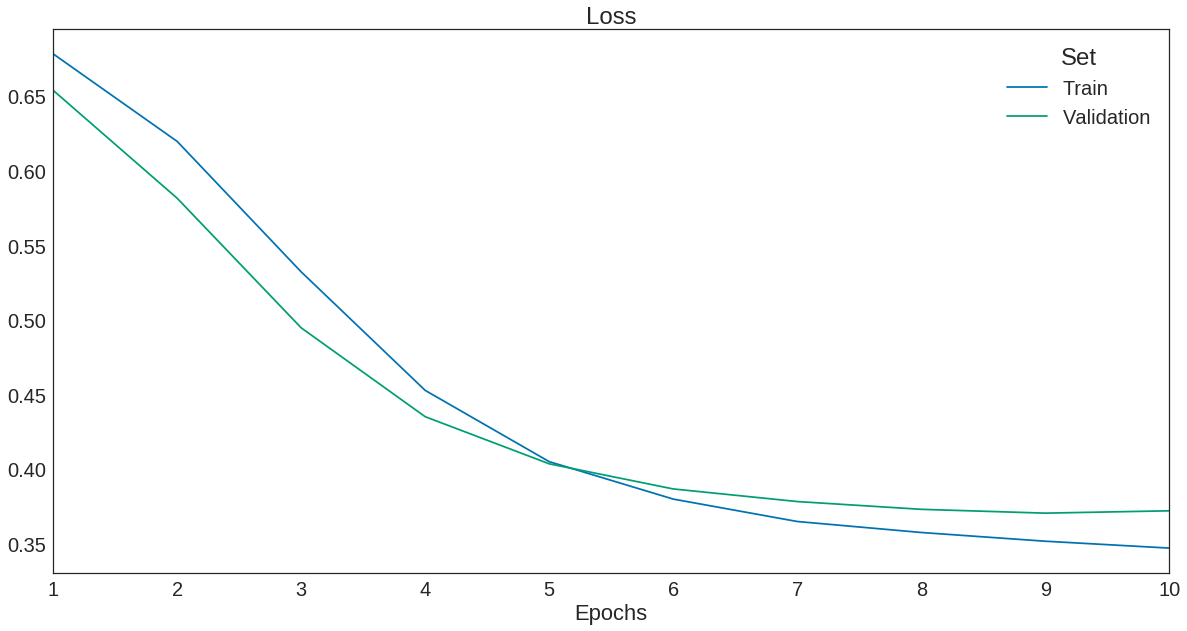

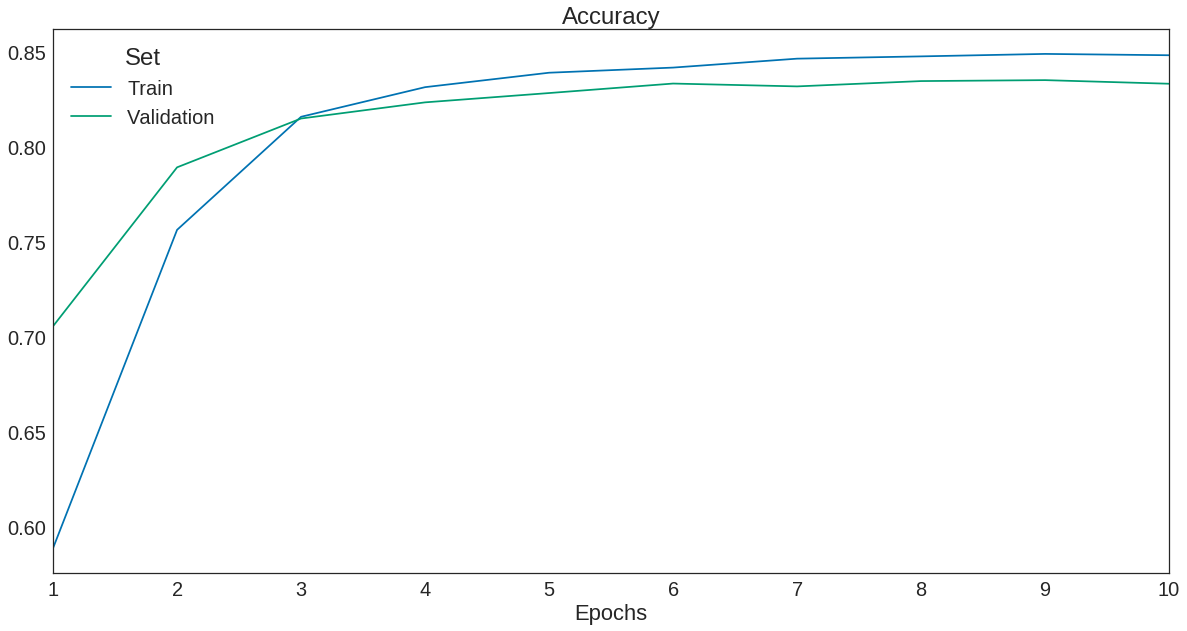

In [15]:
plot_learning_report(learning_reports['v2'])
# improve 3% the network



# by stacking layers: improve the results
# learn how to combine more complex features
# price of adding weights (more computational)
# with dropout => keep overfitting very low

# typical when using strong dropout:
# model performing worse on training set because preventing or using all the neurons

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 89, 64)            3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 44, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 39, 32)            12320     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total para

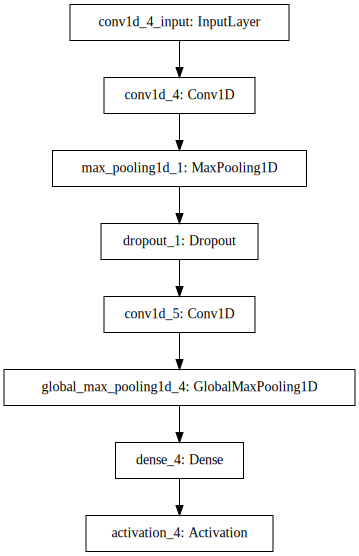

In [16]:
# simple model with kernel_size equal motif size and an additional convolution

# add convolutional layer (go deeper)

filters = 64
kernel_size = 12

model = Sequential()

# apply a first convolutional layer
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(length, number_of_bases)
))

# deeper is better
filters = max(filters//2, 2)
kernel_size = max(kernel_size//2, 2)
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
))

# global max pooling:
model.add(GlobalMaxPooling1D())

# output layer with class prediction
model.add(Dense(1))
model.add(Activation('sigmoid'))


# compilation
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

plot_model(model)

In [17]:
# fitting
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

learning_reports['v3'] = get_learning_report(history)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 6s 555us/step - loss: 0.6528 - acc: 0.6327 - val_loss: 0.5732 - val_acc: 0.7444
Epoch 2/10
10000/10000 [==============================] - 4s 390us/step - loss: 0.5030 - acc: 0.7764 - val_loss: 0.4189 - val_acc: 0.8212
Epoch 3/10
10000/10000 [==============================] - 4s 415us/step - loss: 0.3714 - acc: 0.8457 - val_loss: 0.3259 - val_acc: 0.8654
Epoch 4/10
10000/10000 [==============================] - 4s 396us/step - loss: 0.3185 - acc: 0.8669 - val_loss: 0.3057 - val_acc: 0.8712
Epoch 5/10
10000/10000 [==============================] - 4s 394us/step - loss: 0.3044 - acc: 0.8710 - val_loss: 0.2992 - val_acc: 0.8753
Epoch 6/10
10000/10000 [==============================] - 4s 429us/step - loss: 0.3006 - acc: 0.8695 - val_loss: 0.3080 - val_acc: 0.8705
Epoch 7/10
10000/10000 [==============================] - 4s 438us/step - loss: 0.2957 - acc: 0.8752 - val_loss: 0.2949 - 

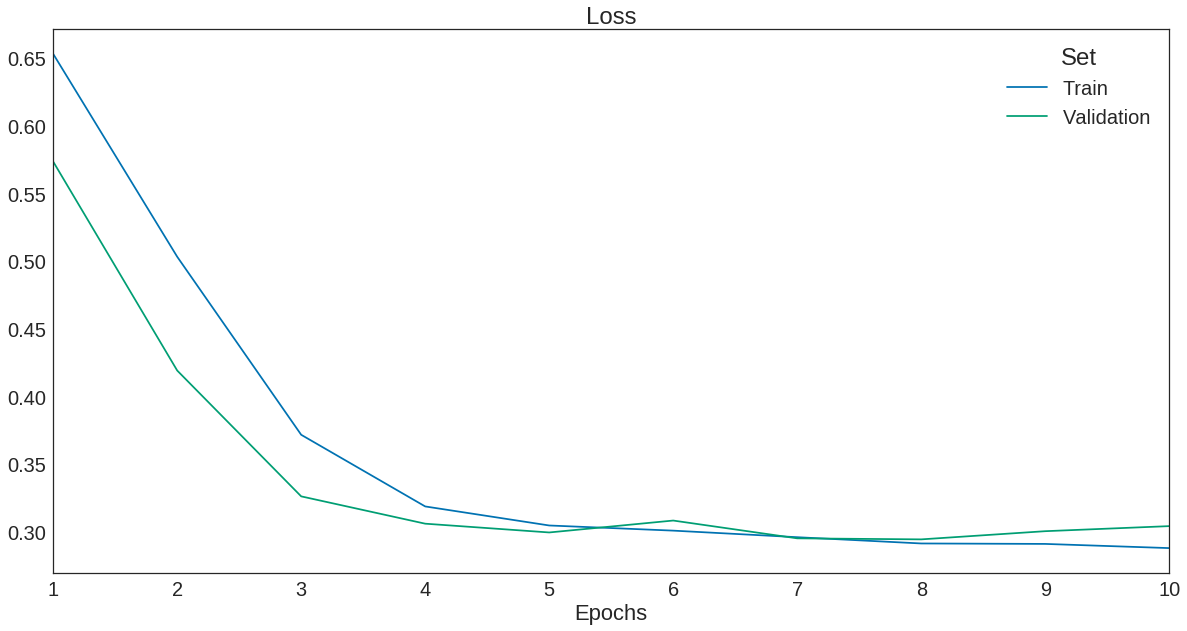

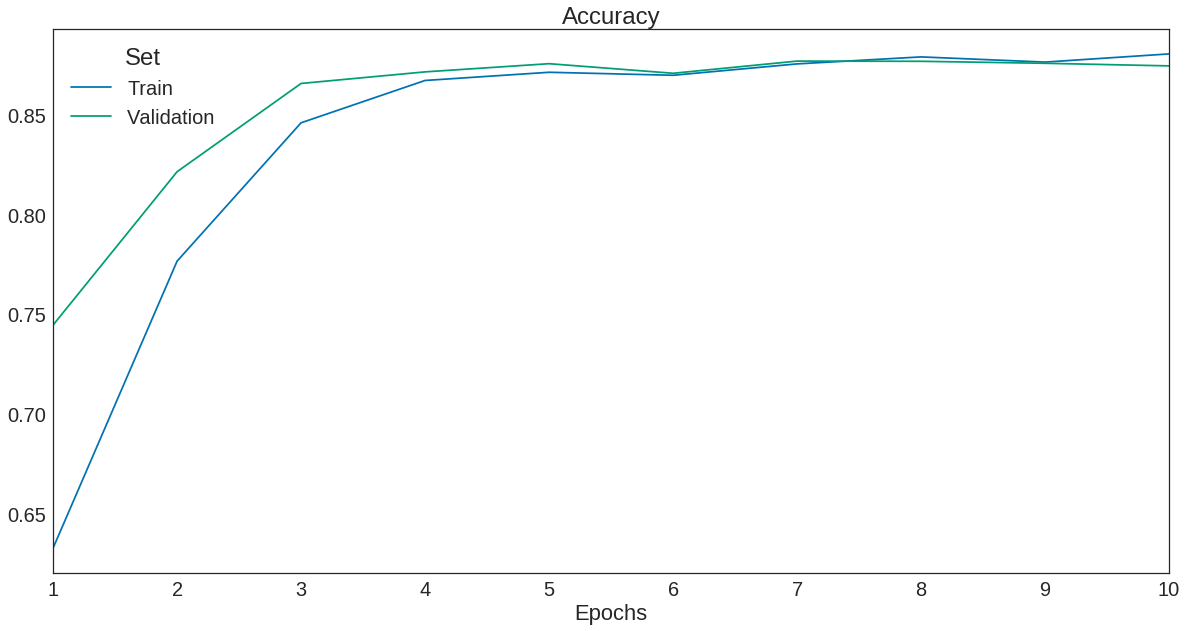

In [18]:
plot_learning_report(learning_reports['v3'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 89, 64)            3136      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 44, 64)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 44, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 39, 32)            12320     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 17, 16)            1552      
__________

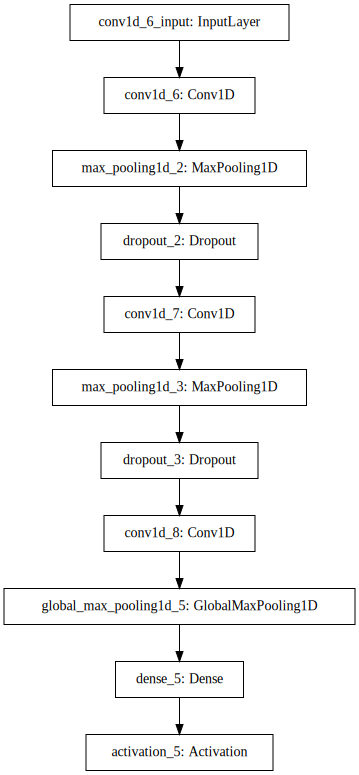

In [19]:
# simple model with kernel_size equal motif size and two additional convolutions
filters = 64
kernel_size = 12

model = Sequential()

# apply a first convolutional layer
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(length, number_of_bases)
))

# deeper is better
filters = max(filters//2, 2)
kernel_size = max(kernel_size//2, 2)
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
))

# even deeper is even better
filters = max(filters//2, 2)
kernel_size = max(kernel_size//2, 2)
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
))

# global max pooling:
model.add(GlobalMaxPooling1D())

# output layer with class prediction
model.add(Dense(1))
model.add(Activation('sigmoid'))


# compilation
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

plot_model(model)

In [20]:
# fitting
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

learning_reports['v4'] = get_learning_report(history)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 4s 414us/step - loss: 0.6502 - acc: 0.6304 - val_loss: 0.5559 - val_acc: 0.7296
Epoch 2/10
10000/10000 [==============================] - 4s 429us/step - loss: 0.4846 - acc: 0.7765 - val_loss: 0.4208 - val_acc: 0.7986
Epoch 3/10
10000/10000 [==============================] - 4s 358us/step - loss: 0.3259 - acc: 0.8639 - val_loss: 0.2610 - val_acc: 0.8994
Epoch 4/10
10000/10000 [==============================] - 4s 351us/step - loss: 0.2696 - acc: 0.8907 - val_loss: 0.3052 - val_acc: 0.8751
Epoch 5/10
10000/10000 [==============================] - 3s 348us/step - loss: 0.2556 - acc: 0.8974 - val_loss: 0.2491 - val_acc: 0.9055
Epoch 6/10
10000/10000 [==============================] - 4s 351us/step - loss: 0.2493 - acc: 0.8992 - val_loss: 0.2811 - val_acc: 0.8924
Epoch 7/10
10000/10000 [==============================] - 4s 399us/step - loss: 0.2399 - acc: 0.9024 - val_loss: 0.2399 - 

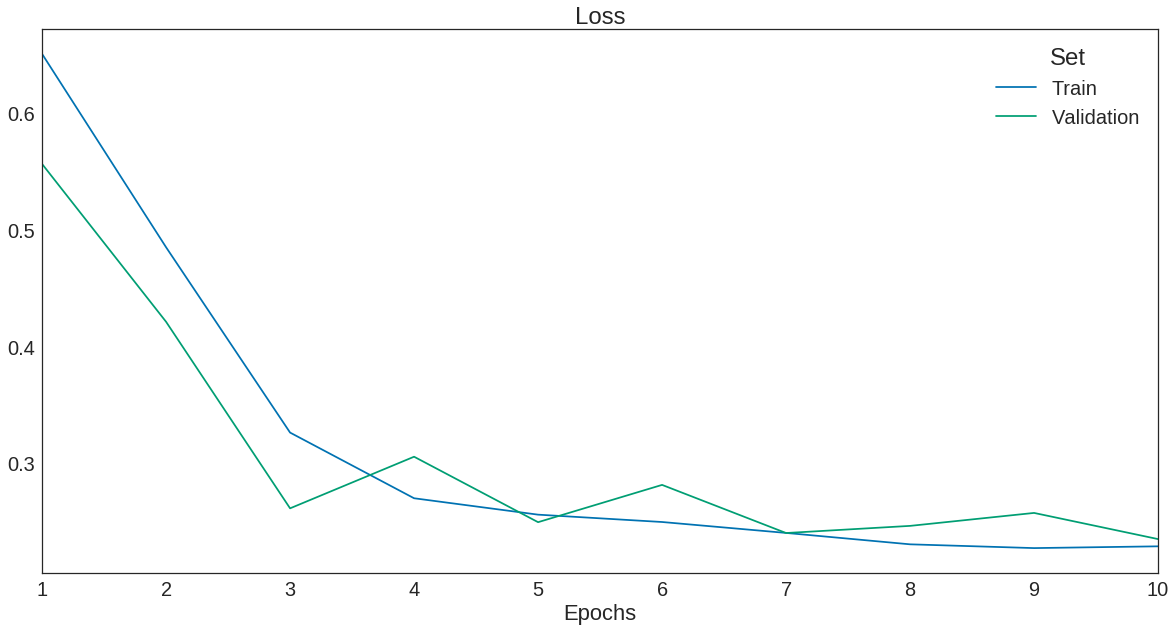

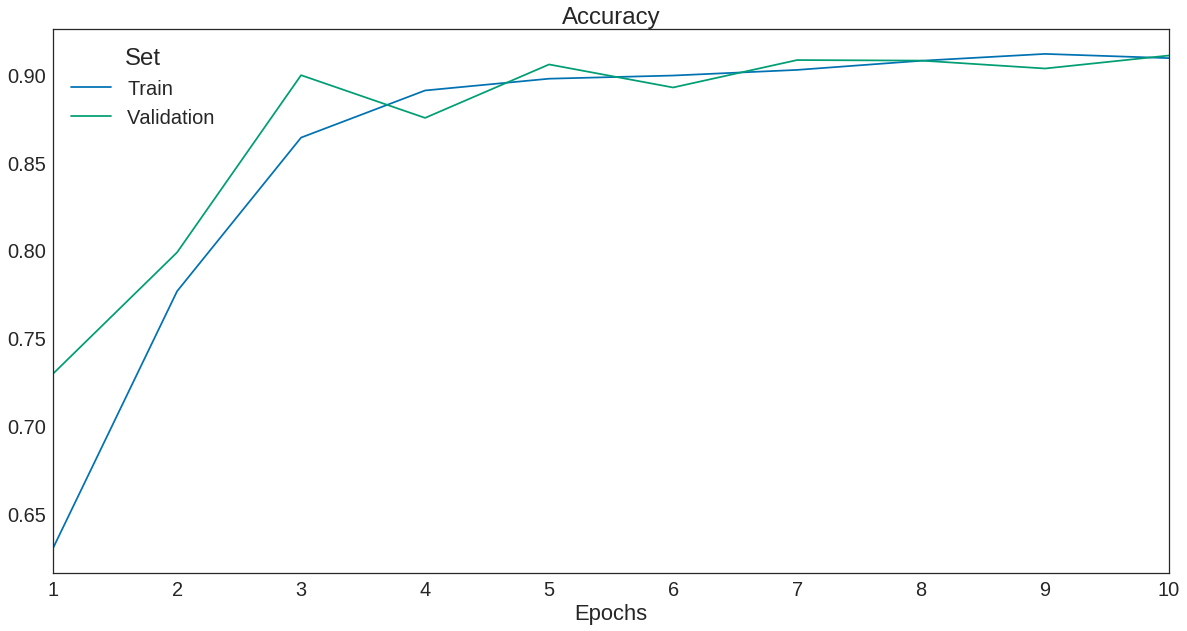

In [21]:
plot_learning_report(learning_reports['v4'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 89, 64)            3136      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 44, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 44, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 39, 32)            12320     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 17, 16)            1552      
__________

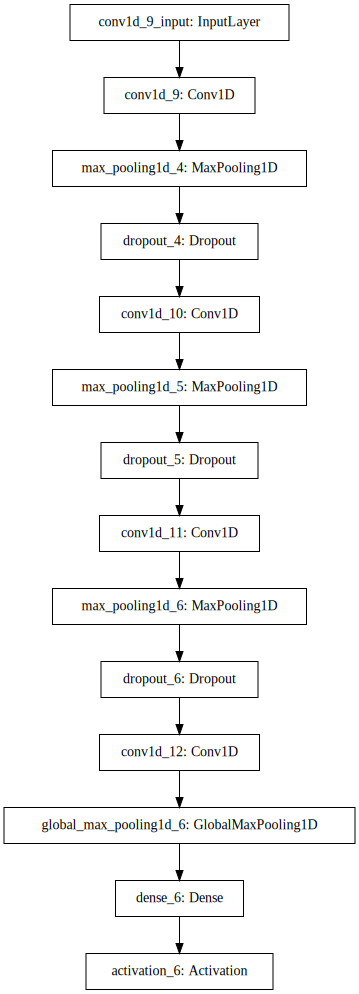

In [22]:
# simple model with kernel_size equal motif size and three additional convolutions
filters = 64
kernel_size = 12

model = Sequential()

# apply a first convolutional layer
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(length, number_of_bases)
))

# deeper is better
filters = max(filters//2, 2)
kernel_size = max(kernel_size//2, 2)
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
))

# even deeper is even better
filters = max(filters//2, 2)
kernel_size = max(kernel_size//2, 2)
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
))

# abyssal would be the best
filters = max(filters//2, 2)
kernel_size = max(kernel_size//2, 2)
model.add(MaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
))

# global max pooling:
model.add(GlobalMaxPooling1D())

# output layer with class prediction
model.add(Dense(1))
model.add(Activation('sigmoid'))


# compilation
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

plot_model(model)

In [23]:
# fitting
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

learning_reports['v5'] = get_learning_report(history)

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 4s 364us/step - loss: 0.6942 - acc: 0.5120 - val_loss: 0.6896 - val_acc: 0.5436
Epoch 2/10
10000/10000 [==============================] - 4s 370us/step - loss: 0.6643 - acc: 0.6406 - val_loss: 0.6195 - val_acc: 0.6881
Epoch 3/10
10000/10000 [==============================] - 4s 413us/step - loss: 0.5493 - acc: 0.7251 - val_loss: 0.5106 - val_acc: 0.7825
Epoch 4/10
10000/10000 [==============================] - 3s 348us/step - loss: 0.4686 - acc: 0.7865 - val_loss: 0.4296 - val_acc: 0.8097
Epoch 5/10
10000/10000 [==============================] - 4s 353us/step - loss: 0.3296 - acc: 0.8606 - val_loss: 0.2864 - val_acc: 0.8903
Epoch 6/10
10000/10000 [==============================] - 3s 344us/step - loss: 0.2663 - acc: 0.8973 - val_loss: 0.2574 - val_acc: 0.9047
Epoch 7/10
10000/10000 [==============================] - 3s 343us/step - loss: 0.2337 - acc: 0.9104 - val_loss: 0.2439 - 

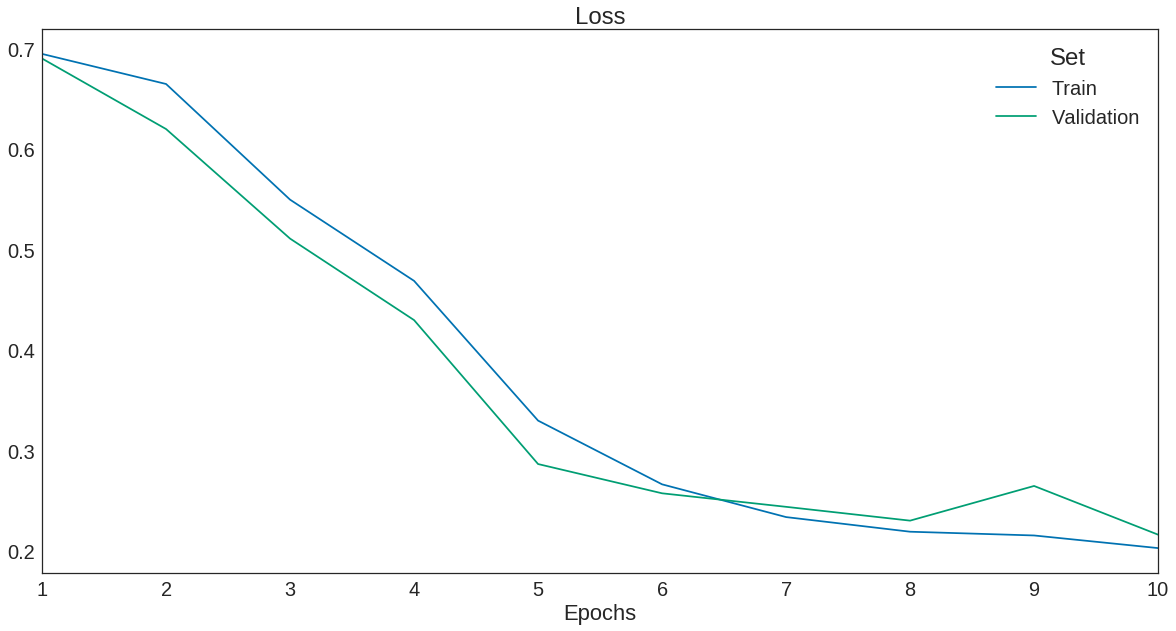

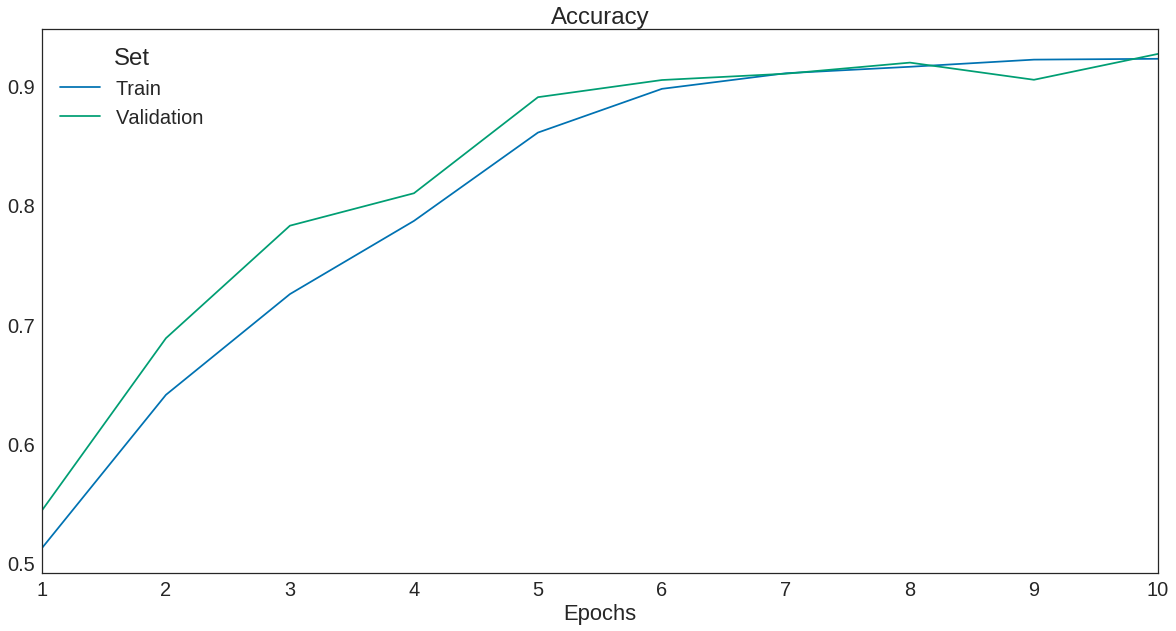

In [24]:
plot_learning_report(learning_reports['v5'])

In [28]:
final_report = pd.Panel(learning_reports)
final_report

<class 'pandas.core.panel.Panel'>
Dimensions: 5 (items) x 10 (major_axis) x 4 (minor_axis)
Items axis: v1 to v5
Major_axis axis: 1 to 10
Minor_axis axis: (Accuracy, Train) to (Loss, Validation)

## Further reading

In case you are more interested about the topic sequences analysis and deep learning we suggest the following publications:
- [Predicting the sequence specificities of DNA- and RNA-binding proteins by deep learning](https://www.nature.com/articles/nbt.3300)
- [DeeperBind: Enhancing Prediction of Sequence Specificities of DNA Binding Proteins](https://arxiv.org/pdf/1611.05777.pdf)
- [Convolutional neural network architectures for predicting DNA–protein binding](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btw255)


deeper bind: more layers (more complex)


In [ ]:
# filters fixed in size
you want to learn 64 filters
these filters are the weights of the network
you can have correlated wieghts (filters). 
look how the filters loook like to see if you need all the filters.
filters could be highly correlated or lots of them might be dying
if all filters have low weights => you can remove it
jsut by plotting the fvectors in a heatmap -> you will see it

plot with accuracy: meaningless without cross-validation
usually at least plot a confidence band for the accuracy
(20-fold cross-validation usually)

with keras you can save all the logs to get all the weights of all the filters

you can visualize how the filters change your image or the values of the weights

problem of class imbalance
- combination of weights on loss function (multiply loss by facotr) penalize performing well on dominant class,
reward performign well least represented class
- balance the dataset upstream to get a balanced training set (even if test dataset is umbalanced) if enough data, 
better to create a balanced training set

in this kind of networks with lots of weights, 70%-30% can lead to overfitting much of the time

hyperopt => very good Python package for hyperparameter optimization
or other based on bayesian, or genetic algorithms

when you get a classification and you want a p-value: not neural network , in other machine learning, 
    you could have from boostraping. in deep learning, too costly
    
    other way: take similar images and look how many times as good as what you get
        
        conv2d to reconstruct the image
        
        kem and gradkem -> kind of heatmap of the filters features